100%|██████████| 9.91M/9.91M [00:00<00:00, 45.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 32.1MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 24.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.03MB/s]


Epoch 1/10 | train 42.9316 | val 25.1621
Epoch 2/10 | train 19.1884 | val 18.3100
Epoch 3/10 | train 13.7493 | val 14.6946
Epoch 4/10 | train 10.2929 | val 13.7494
Epoch 5/10 | train 8.1873 | val 12.0502
Epoch 6/10 | train 6.4496 | val 11.3586
Epoch 7/10 | train 5.6492 | val 11.4503
Epoch 8/10 | train 4.4825 | val 11.5799
Epoch 9/10 | train 3.6315 | val 10.8727
Epoch 10/10 | train 3.0122 | val 12.8601


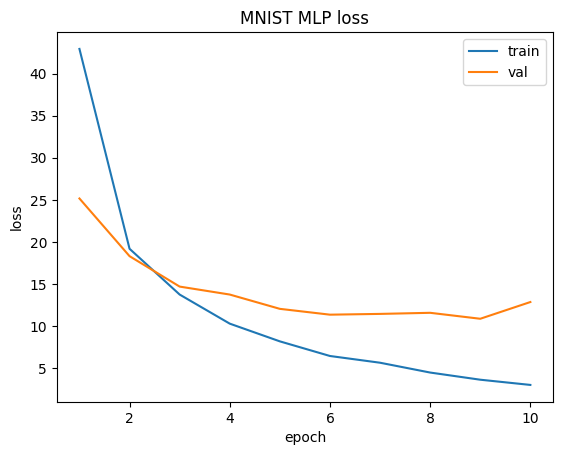

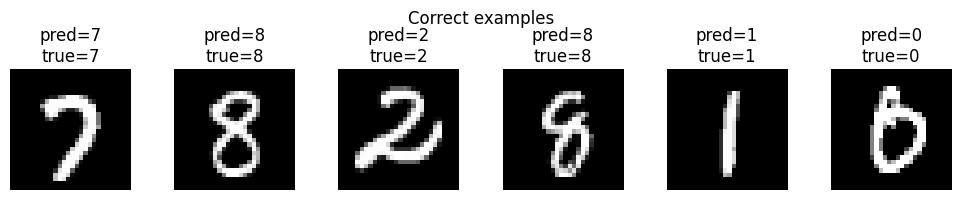

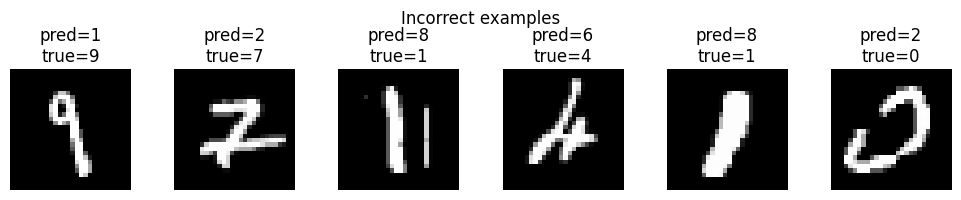

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
import math

seed = 40
MEAN, STD = 0.1307, 0.3081
# 幫手函式：依目前的 mean/std 反/正規化

def unnormalize(x):   # x: normalized tensor
    return x * STD + MEAN
def renormalize(x):   # x: pixel tensor in [0,1]
    return (x - MEAN) / STD


#transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, ), (0.5, ))]) # mean 0.5, standard deviation 0.5
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((MEAN, ), (STD, ))]) # mean 0.13, standard deviation 0.31
train_set = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)
test_set = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True)

gen = torch.Generator().manual_seed(seed)  # easier debug(reproducibility)
train_dataset, val_dataset = torch.utils.data.random_split(train_set, [0.8, 0.2], generator=gen)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size = 128, shuffle=True)


# Creat a Model Class that inherits nn.Module
class NeuralNetwork(nn.Module):
  # Input layer(input 28*28 features) ((28*28=784
  # -> Hidden Layer1(# of neurons)
  # -> output(10 digit categories)
  def __init__(self, in_features=784, h1=128, out_features=10):
    super().__init__() #instantiate out nn.Module
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, out_features)

  def forward(self, x):
      x = self.flatten(x)                  # (N,1,28,28)->(N,784)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

model = NeuralNetwork()


loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []

epochs = 10
for i in range(epochs):

    # train
    model.train()
    runsum = 0.0
    for images, labels in train_loader:
        output = model(images)              # 前向(得到 log 機率)

        loss = loss_function(output, labels)# predicted values vs the y_train values
        optimizer.zero_grad()               # clear gradient
        loss.backward()                     # Backpropagation
        optimizer.step()                    # update parameter

        runsum += loss.item() * images.size(0) # 取這個 batch 的樣本數（第 0 維 = batch 維）,把「這個 batch 的平均 loss」換成「總和」後累加

    train_loss = runsum / len(train_loader)
    train_losses.append(train_loss)


    # validate
    model.eval()
    vsum = 0.0
    with torch.no_grad():                       # basically turn of back propogation
        for x_val, y_val in val_loader:
            vloss = loss_function(model(x_val), y_val)
            vsum += vloss.item() * x_val.size(0)
    val_loss = vsum / len(val_loader)
    val_losses.append(val_loss)


    print(f'Epoch {i+1}/{epochs} | train {train_loss:.4f} | val {val_loss:.4f}')

plt.plot(range(1, epochs+1), train_losses, label='train')
plt.plot(range(1, epochs+1), val_losses, label='val')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('MNIST MLP loss')

plt.legend()
plt.show()


# test
model.eval()
correct_samples, wrong_samples = [], []
with torch.no_grad():
    for x, y in test_loader:
        logits = model(x)
        pred = logits.argmax(1)
        for i in range(x.size(0)):
            img = unnormalize(x[i, 0]).cpu()        # (28,28)
            p, t = int(pred[i]), int(y[i])
            if p == t and len(correct_samples) < 6:
                correct_samples.append((img, p, t))
            elif p != t and len(wrong_samples) < 6:
                wrong_samples.append((img, p, t))
        if len(correct_samples) >= 6 and len(wrong_samples) >= 6:
            break

def show(samples, title):
    plt.figure(figsize=(10, 2))

    for i, (img, p, t) in enumerate(samples, 1):
        plt.subplot(1, len(samples), i)
        plt.imshow(img.clamp(0, 1), cmap='gray')
        plt.axis('off')
        plt.title(f'pred={p}\ntrue={t}')

    plt.tight_layout(rect=[0, 0, 1, 0.86])
    plt.suptitle(title)
    plt.show()

show(correct_samples, 'Correct examples')
show(wrong_samples,   'Incorrect examples')


# 1b. constant offsets attack

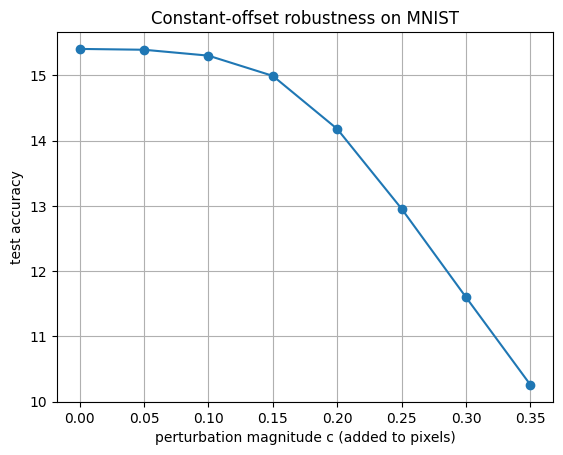

In [2]:
# 掃一系列常數偏移 c，計算 test accuracy
magnitudes = [0,0.05,0.10,0.15,0.20,0.25,0.30,0.35]  # 可加/改
accs = []

model.eval()
with torch.no_grad():
    for c in magnitudes:

        correct = 0

        for x, y in test_loader:
            # x 目前是「Normalize 之後」的張量 → 先還原到 [0,1] 再加常數，最後夾回 [0,1]
            x_pixel = unnormalize(x)                      # 回到 [0,1] 空間
            x_pert  = torch.clamp(x_pixel + c, 0.0, 1.0)  # 加常數偏移並 clip 進 [0,1]
            x_norm  = renormalize(x_pert)                 # 再正規化，與訓練同尺度餵模型

            logits = model(x_norm)
            pred   = logits.argmax(1)
            correct += (pred == y).sum().item()

        accs.append(correct / (len(magnitudes)*len(test_loader)))

# plot
plt.figure()
plt.plot(magnitudes, accs, marker='o')
plt.xlabel('perturbation magnitude c (added to pixels)')
plt.ylabel('test accuracy')
plt.title('Constant-offset robustness on MNIST')
plt.grid(True)
plt.show()

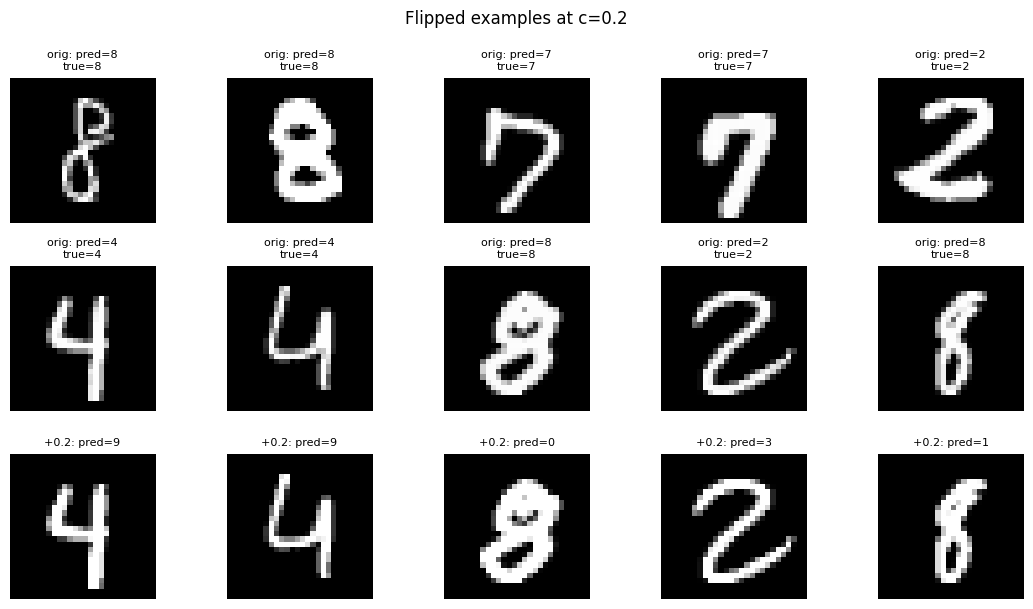

In [3]:
c_show = 0.20
c_flip = []  # (orig, pert, pred_orig, pred_pert, label)

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x_pix   = unnormalize(x)
        x_pert  = torch.clamp(x_pix + c_show, 0.0, 1.0)
        p0 = model(renormalize(x_pix)).argmax(1) # 各自用同樣正規化進模型
        p1 = model(renormalize(x_pert)).argmax(1)

        idxs = ((p0 == y) & (p1 != y)).nonzero(as_tuple=True)[0]# 原本判對、擾動後判錯
        for idx in idxs[:10 - len(c_flip)]:  # 收集最多 10 張
            c_flip.append((x_pix[idx, 0].cpu(), x_pert[idx, 0].cpu(), int(p0[idx]), int(p1[idx]), int(y[idx])))
        if len(c_flip) >= 10:
            break

# 排版顯示：每個樣本顯示「原圖 / 擾動圖」一對
cols = 5
rows = math.ceil(len(c_flip) / cols)
plt.figure(figsize=(2.2*cols, 4.0*rows))

for i, (orig, pert, p0, p1, t) in enumerate(c_flip, 1):
    # 原圖
    ax = plt.subplot(rows*2, cols, i)
    ax.imshow(orig.clamp(0, 1), cmap='gray')
    ax.axis('off')
    ax.set_title(f'orig: pred={p0}\ntrue={t}', fontsize=8)
    # 擾動圖
    ax = plt.subplot(rows*2, cols, i+cols)
    ax.imshow(pert.clamp(0, 1), cmap='gray')
    ax.axis('off')
    ax.set_title(f'+{c_show}: pred={p1}', fontsize=8)

plt.suptitle(f'Flipped examples at c={c_show}', y=0.99)
plt.tight_layout()
plt.show()


# 1c

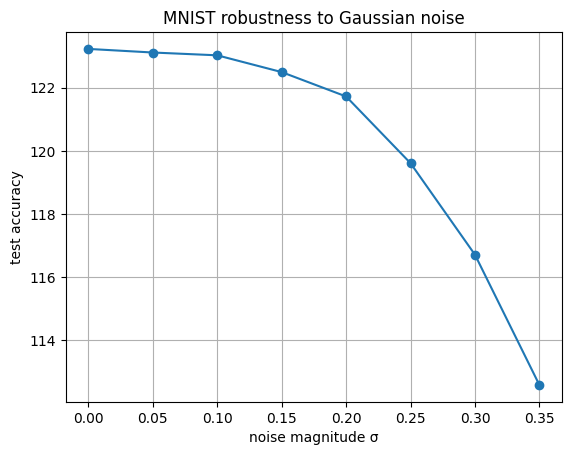

In [4]:
accs = []

model.eval()
with torch.no_grad():
    for sigma in magnitudes:
        correct =  0
        for x, y in test_loader:
            x_pix = unnormalize(x)  # 先回到像素空間
            noise = sigma * torch.randn(x_pix.shape)  # N(0, sigma^2) noise
            x_noisy = torch.clamp(x_pix + noise, 0.0, 1.0)  # 夾回 [0,1]
            x_norm = renormalize(x_noisy)  # 再正規化到和訓練一致的尺度

            pred = model(x_norm).argmax(1)
            correct += (pred == y).sum().item()
        accs.append(correct / len(test_loader))

plt.figure()
plt.plot(magnitudes, accs, marker='o')
plt.xlabel('noise magnitude σ')
plt.ylabel('test accuracy')
plt.title('MNIST robustness to Gaussian noise')
plt.grid(True)
plt.show()

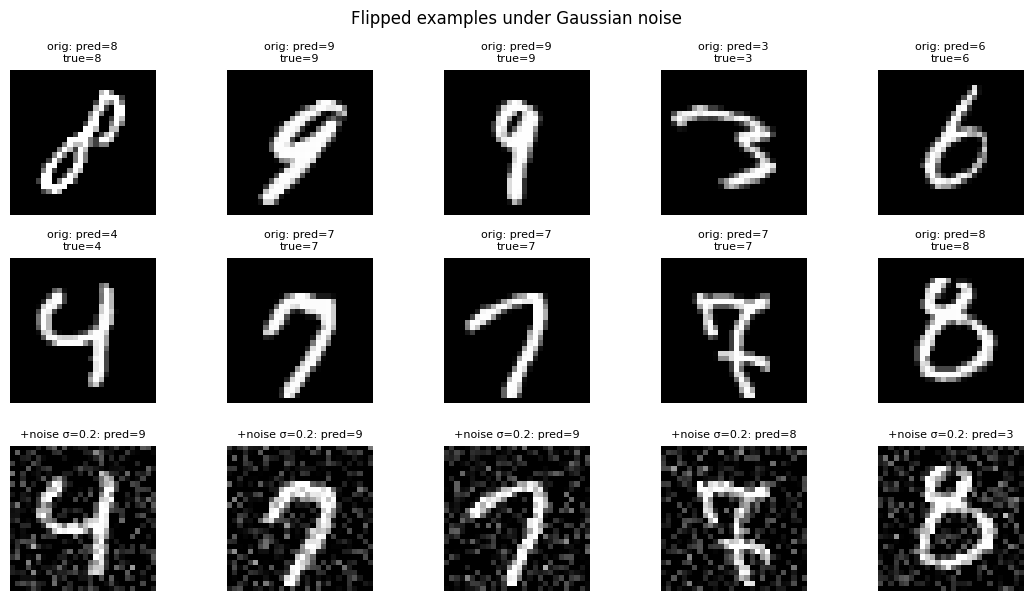

In [5]:
sigma_show = 0.20
sigma_flip = []  # (orig, noisy_img, pred_orig, pred_pert, label)

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x_pix = unnormalize(x)
        x_noisy = torch.clamp(x_pix + sigma_show * torch.randn(x_pix.shape), 0.0, 1.0)
        p0 = model(renormalize(x_pix)).argmax(1)
        p1 = model(renormalize(x_noisy)).argmax(1)

        idxs = ((p0 == y) & (p1 != y)).nonzero(as_tuple=True)[0]
        for i in idxs[:10 - len(sigma_flip)]:
            sigma_flip.append((x_pix[i,0].cpu(), x_noisy[i,0].cpu(), int(p0[i]), int(p1[i]), int(y[i])))
        if len(sigma_flip) >= 10:
            break



cols = 5
rows = math.ceil(len(sigma_flip)/5)
plt.figure(figsize=(2.2*cols, 4.0*rows))

for i,(orig, noisy, p0, p1, t) in enumerate(sigma_flip,1):

    ax = plt.subplot(rows*2, cols, i)
    ax.imshow(orig, cmap='gray')
    ax.axis('off')
    ax.set_title(f'orig: pred={p0}\ntrue={t}', fontsize=8)

    ax = plt.subplot(rows*2, cols, i+cols)
    ax.imshow(noisy, cmap='gray')
    ax.axis('off')
    ax.set_title(f'+noise σ={sigma_show}: pred={p1}', fontsize=8)
plt.suptitle('Flipped examples under Gaussian noise')
plt.tight_layout()
plt.show()

# 1d

epsilon=0.00  FGSM test acc = 123.2278
epsilon=0.02  FGSM test acc = 116.3797
epsilon=0.05  FGSM test acc = 84.1899
epsilon=0.10  FGSM test acc = 20.2532
epsilon=0.15  FGSM test acc = 5.2152
epsilon=0.20  FGSM test acc = 2.6962
epsilon=0.30  FGSM test acc = 0.4810


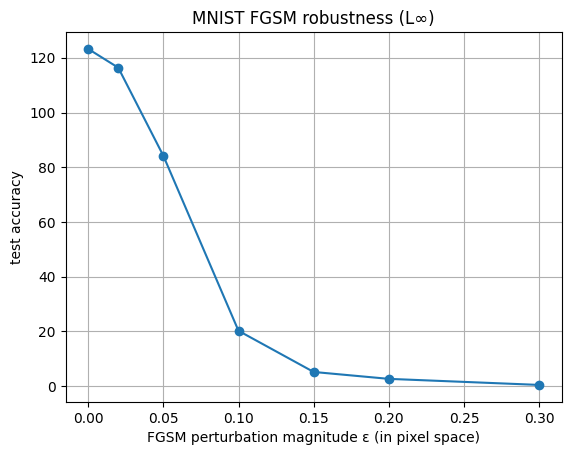

In [6]:
# === FGSM: test accuracy vs epsilon ===
model.eval()

eps_list = [0.00, 0.02, 0.05, 0.10, 0.15, 0.20, 0.30]  # 像素域幅度 (0~1)
acc_fgsm = []

# 正規化域的上下界：等價於像素 clamp 到 [0,1]
lower = (0.0 - MEAN) / STD
upper = (1.0 - MEAN) / STD


for eps in eps_list:
    correct = 0
    for x, y in test_loader:
        # x 目前是 Normalize 後；我們直接在「正規化域」做 FGSM
        x_adv = x.clone().detach().requires_grad_(True)
        logits = model(x_adv)
        loss = loss_function(logits, y)

        # 只要 x 的梯度，不更新模型權重
        model.zero_grad(set_to_none=True)
        loss.backward()

        # 像素域 epsilon 轉到正規化域：eps_norm = eps / STD
        eps_norm = eps / STD
        grad_sign = x_adv.grad.detach().sign()
        x_adv = x_adv + eps_norm * grad_sign

        # clip 回「正規化域」的合法範圍（對應像素在 [0,1]）
        x_adv = torch.clamp(x_adv, lower, upper)

        with torch.no_grad():
            pred = model(x_adv).argmax(1)
            correct += (pred == y).sum().item()

    acc = correct / len(test_loader)
    acc_fgsm.append(acc)
    print(f'epsilon={eps:.2f}  FGSM test acc = {acc:.4f}')

# 繪圖
plt.figure()
plt.plot(eps_list, acc_fgsm, marker='o')
plt.xlabel('FGSM perturbation magnitude ε (in pixel space)')
plt.ylabel('test accuracy')
plt.title('MNIST FGSM robustness (L∞)')
plt.grid(True)
plt.show()


# 1e

# Q2

# 2a

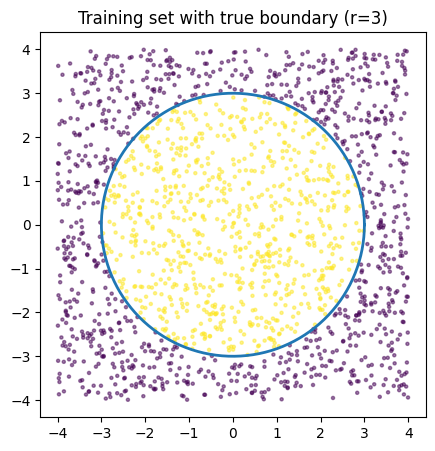

In [7]:
# ChatGPT 2a
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)
torch.manual_seed(42)

r = 3.0                       # circle radius
N = 3000                      # total samples

# Sample points uniformly in the square
X = rng.uniform(-4, 4, size=(N, 2)).astype(np.float32)
# Labels: 1 inside circle, 0 outside
y = (np.sum(X**2, axis=1) <= r**2).astype(np.float32)

# Train/Val/Test split (60/20/20)
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val,   X_test, y_val,   y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

# Torch tensors + loaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=512, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False)

# Quick plot: training points + true boundary
theta = np.linspace(0, 2*np.pi, 400)
circle = np.c_[r*np.cos(theta), r*np.sin(theta)]
plt.figure(figsize=(5,5))
plt.scatter(X_train[:,0], X_train[:,1], s=5, c=y_train, alpha=0.5)
plt.plot(circle[:,0], circle[:,1], linewidth=2)    # true boundary
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Training set with true boundary (r=3)')
plt.show()



# 2b

/tmp/ipython-input-191847381.py:31: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  total_loss += float(loss) * xb.size(0)


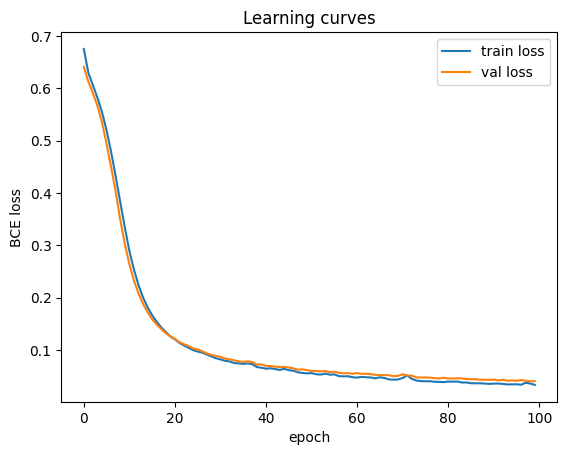

Test accuracy: 0.9900


In [8]:
# ChatGPT 2b
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)   # logits
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)  # shape: (B,)

model = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # weight_decay = L2 reg

def run_epoch(dl, train):
    total_loss, total_n = 0.0, 0
    if train: model.train()
    else:     model.eval()
    for xb, yb in dl:
        if train:
            optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += float(loss) * xb.size(0)
        total_n += xb.size(0)
    return total_loss / total_n

train_losses, val_losses = [], []
best_val, best_state = float('inf'), None

for epoch in range(100):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader,   train=False)
    train_losses.append(tr); val_losses.append(va)
    if va < best_val:
        best_val, best_state = va, {k: v.cpu().clone() for k, v in model.state_dict().items()}
    # (optional) early stop patience; here we just keep 100 epochs

# load best model
model.load_state_dict(best_state)

# Plot learning curves
plt.figure()
plt.plot(train_losses, label='train loss')
plt.plot(val_losses,   label='val loss')
plt.xlabel('epoch'); plt.ylabel('BCE loss'); plt.legend(); plt.title('Learning curves')
plt.show()

# Test accuracy
model.eval()
with torch.no_grad():
    all_logits, all_y = [], []
    for xb, yb in test_loader:
        all_logits.append(model(xb))
        all_y.append(yb)
    logits = torch.cat(all_logits)
    y_true = torch.cat(all_y)
    y_prob = torch.sigmoid(logits)
    y_pred = (y_prob >= 0.5).float()
    acc = (y_pred == y_true).float().mean().item()
print(f"Test accuracy: {acc:.4f}")



# 2c

IoU (grid-based): 0.9808


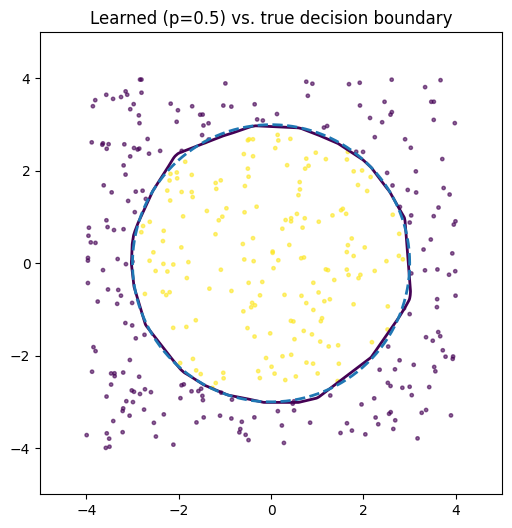

In [9]:
# ChatGPT 2c ====
gx = np.linspace(-5, 5, 400, dtype=np.float32)
gy = np.linspace(-5, 5, 400, dtype=np.float32)
GX, GY = np.meshgrid(gx, gy)
grid = np.stack([GX.ravel(), GY.ravel()], axis=1)
with torch.no_grad():
    probs = torch.sigmoid(model(torch.from_numpy(grid))).numpy().reshape(GX.shape)

# True mask on grid for IoU (optional metric)
true_mask = (GX**2 + GY**2 <= r**2)
pred_mask = (probs >= 0.5)
intersection = np.logical_and(true_mask, pred_mask).sum()
union = np.logical_or(true_mask, pred_mask).sum()
iou = intersection / union
print(f"IoU (grid-based): {iou:.4f}")

# Plot learned boundary (p=0.5 contour) vs. true circle
plt.figure(figsize=(6,6))
# decision boundary: p=0.5
CS = plt.contour(GX, GY, probs, levels=[0.5], linewidths=2)
# true boundary
plt.plot(circle[:,0], circle[:,1], linewidth=2, linestyle='--')
# (optional) scatter a thin slice of test points to see errors
idx = np.random.choice(len(X_test), size=400, replace=False)
plt.scatter(X_test[idx,0], X_test[idx,1], s=6, c=y_test[idx], alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Learned (p=0.5) vs. true decision boundary')
plt.show()
